In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import integrate
import tensorflow as tf
from scipy.signal import argrelextrema

Hamiltonian for harmonic oscilator <br>
$H = \frac{p^2}{2m} + \frac{1}{2}kq^2$ <br>
$\dot{q} = \frac{p}{m}$<br>
$\dot{p} = kq$


In [7]:
class Oscillator:
    def __init__(self,q,k,m,dt,t_end):
        self.q = q
        self.p = 0
        self.dt = dt
        self.t_end = t_end
        self.k = k
        self.m = m
        
    # Hamiltonian system
    def f(self,t,r):
        q, p = r
        k = self.k
        m = self.m
        
        q_dot = p/m
        p_dot = -k*q 
    
        return q_dot, p_dot
    
    def solve(self):
        traj = integrate.solve_ivp(self.f,(0,t_end),(self.q,self.p),max_step = self.dt, atol = 1, method = 'RK45')
        return np.array((traj.y[0],traj.y[1],traj.t))

In [8]:
# Constants
k = 1
m = 1
dt = 0.02
t_end = 50
# IC's
q = 1
osc_1 = Oscillator(q,k+4,m,dt,t_end)
osc_2 = Oscillator(q,k+8,m,dt,t_end)

traj = np.reshape(np.array(([osc_1.solve()[0] + osc_2.solve()[0]],[osc_1.solve()[1] + osc_2.solve()[1]],[osc_1.solve()[2]])),(3,osc_1.solve().shape[1])) #(q,p,t)

Text(0, 0.5, 'x')

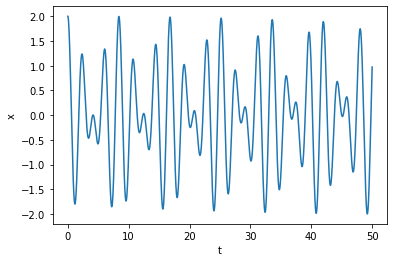

In [26]:
plt.plot(traj[2],traj[0])
plt.xlabel('t'); plt.ylabel('x')

In [10]:
fourierTransform = np.fft.fft(traj[0])/len(traj[0])           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(traj[0])/2))] # Exclude sampling frequency
tpCount     = len(traj[0])
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/(1/.02)
frequencies = values/timePeriod

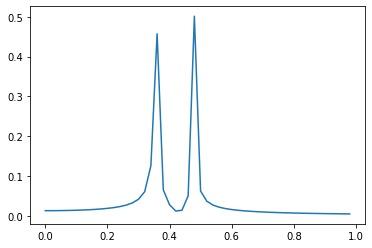

In [11]:
plt.plot(frequencies[0:50], abs(fourierTransform)[0:50])

https://pythontic.com/visualization/signals/fouriertransform_fft

In [157]:
n_M_list = np.array([10,30,50,70,90,120,150])
state_size_list = np.array([10,30,50,70,90,120,150])

In [158]:
class LSTM_model():
    def __init__(self, n_M, state_size):
        self.n_M = n_M
        self.state_size = state_size
    
    def gen_data(self,traj,train_size):
        # Convert data to NN format
        self.traj = traj
        self.train_size = train_size
        train_count = 0
        train_in = np.zeros((2,train_size,self.n_M+1)) # q and p
        train_out  = np.zeros((2,train_size)) # q and p

        for i in range(train_size): # Loop through trajectory
            init_t = int(np.floor(np.random.uniform(0,t_end/dt+1-(self.n_M+2))))
            train_in[:,train_count,:] = traj[0:2,init_t:init_t+self.n_M+1] # n-n_m to n points (ie. current n and all memories)
            train_out[:,train_count] = traj[0:2,init_t+self.n_M+1] # n+1 point
            train_count += 1
            
        self.train_in = train_in
        self.train_out = train_out
        
    def build_model(self):
        inputs = tf.keras.Input((self.n_M+1,1))
        layer = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(self.state_size))(inputs)
        outputs = tf.keras.layers.Dense(1)(layer)
        model = tf.keras.Model(inputs,outputs)
        #model.summary(line_length = 200)
        self.model = model
        
    def train_model(self,batch_size,epochs):
        tf.random.set_seed(0)
        optimizer = tf.keras.optimizers.Adam(lr = .001)
        self.model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
        history  = self.model.fit(self.train_in[0,:,:].reshape(self.train_size,-1,1).astype('float32'),
                                  self.train_out[0,:].reshape(self.train_size,1).astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)
        optimizer = tf.keras.optimizers.Adam(lr = .0001)
        self.model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
        history  = self.model.fit(self.train_in[0,:,:].reshape(self.train_size,-1,1).astype('float32'),
                                  self.train_out[0,:].reshape(self.train_size,1).astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)
        optimizer = tf.keras.optimizers.Adam(lr = .00001)
        self.model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
        history  = self.model.fit(self.train_in[0,:,:].reshape(self.train_size,-1,1).astype('float32'),
                                  self.train_out[0,:].reshape(self.train_size,1).astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)
        
    def predict(self,length):
        S = np.zeros((1,length+2))
        S[0,0:self.n_M+1] = self.traj[0,0:self.n_M+1]
        t = self.traj[2,0:length+2]
        for i in range(length+3-(self.n_M+2)): # 0 to 20 by 0.02 in time
            S[0,i+self.n_M+1] = self.model.predict(np.reshape(S[0,i:i+self.n_M+1],(1,self.n_M+1,1)))
        
        self.ground_truth = np.array([traj[2,0:length+2],traj[0,0:length+2]])
        self.prediction = np.array([traj[2,0:length+2],S[0,:]])
        
    def get_pred(self):
        return self.ground_truth,self.prediction

In [159]:
def run_model(n_M,state_size):
    test = LSTM_model(n_M,state_size)
    test.gen_data(traj,1000)
    test.build_model()
    test.train_model(5,10)
    test.predict(1000)
    gt, pred = test.get_pred()
    return gt, pred, test

In [160]:
def fast_fourier(traj):
    fourierTransform = np.fft.fft(traj)/len(traj)           # Normalize amplitude
    fourierTransform = fourierTransform[range(int(len(traj)/2))] # Exclude sampling frequency
    tpCount     = len(traj)
    values      = np.arange(int(tpCount/2))
    timePeriod  = tpCount/(1/.02)
    frequencies = values/timePeriod
    return frequencies, fourierTransform

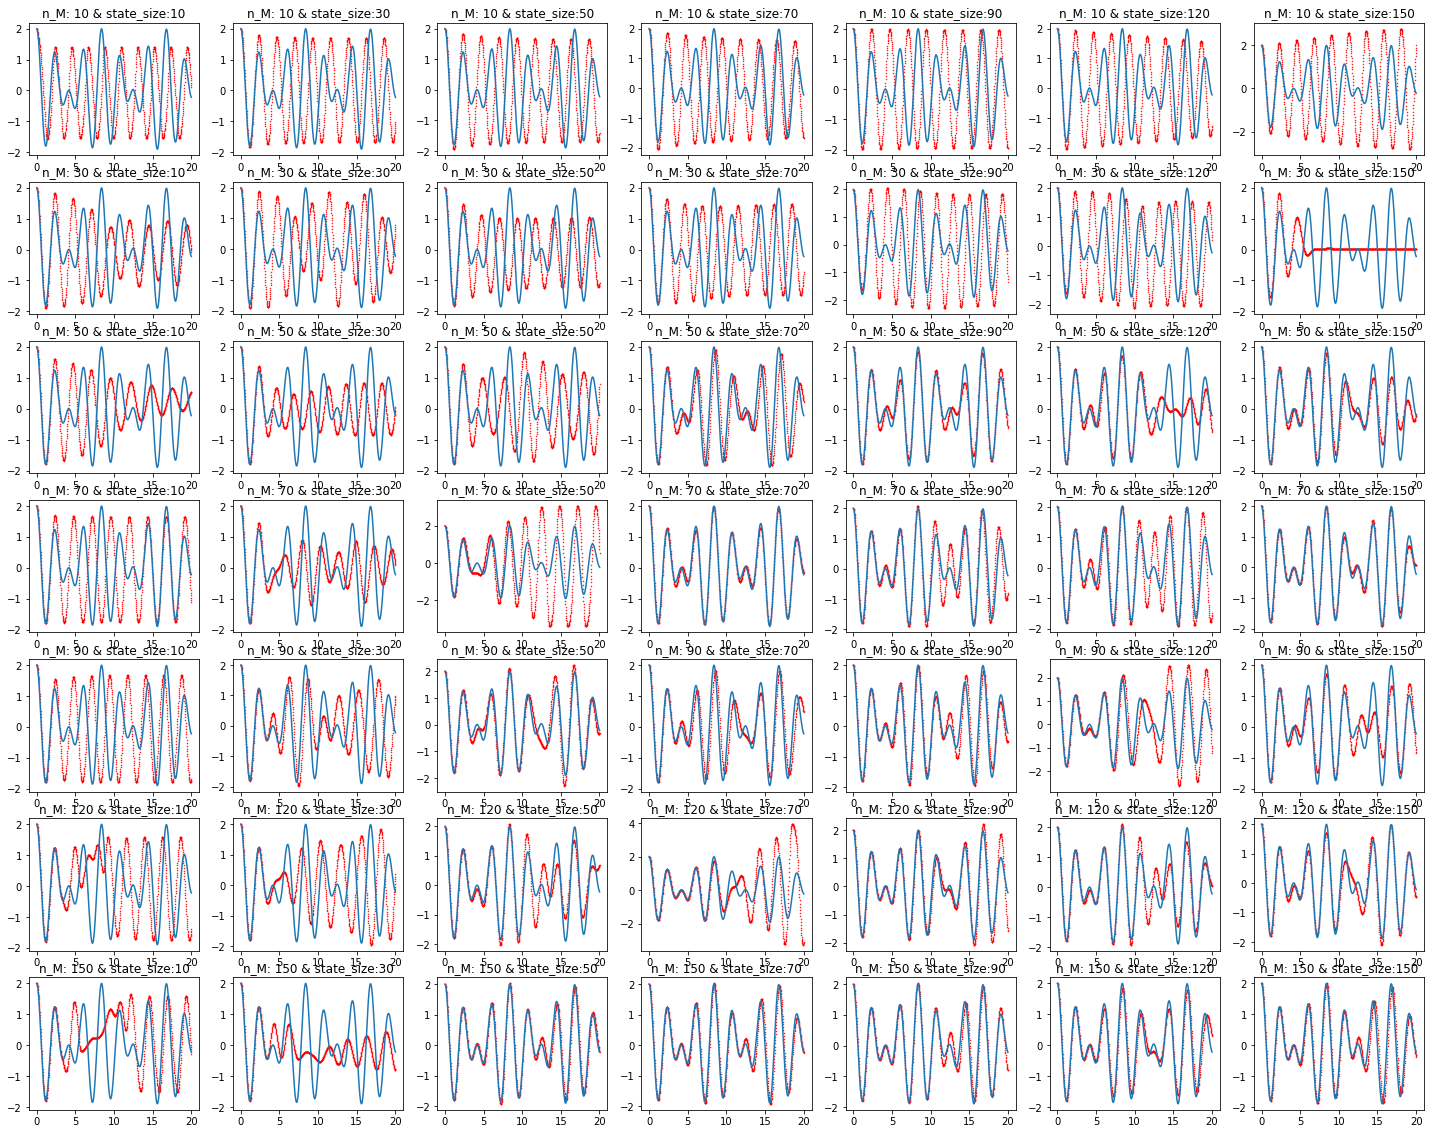

In [161]:
fig, ax = plt.subplots(n_M_list.size,state_size_list.size,figsize=(25,20))
model_list = []
for i in range(n_M_list.size):
    for j in range(state_size_list.size):
        n_M = n_M_list[i]
        state_size = state_size_list[j]
        gt, pred, test = run_model(n_M,state_size)
        model_list.append(test)
        # Plot q
        ax[i, j].set_title('n_M: '+str(n_M) +' & state_size:'+str(state_size))
        ax[i, j].plot(gt[0],gt[1])
        ax[i, j].scatter(pred[0],pred[1],c='r',s=.25)

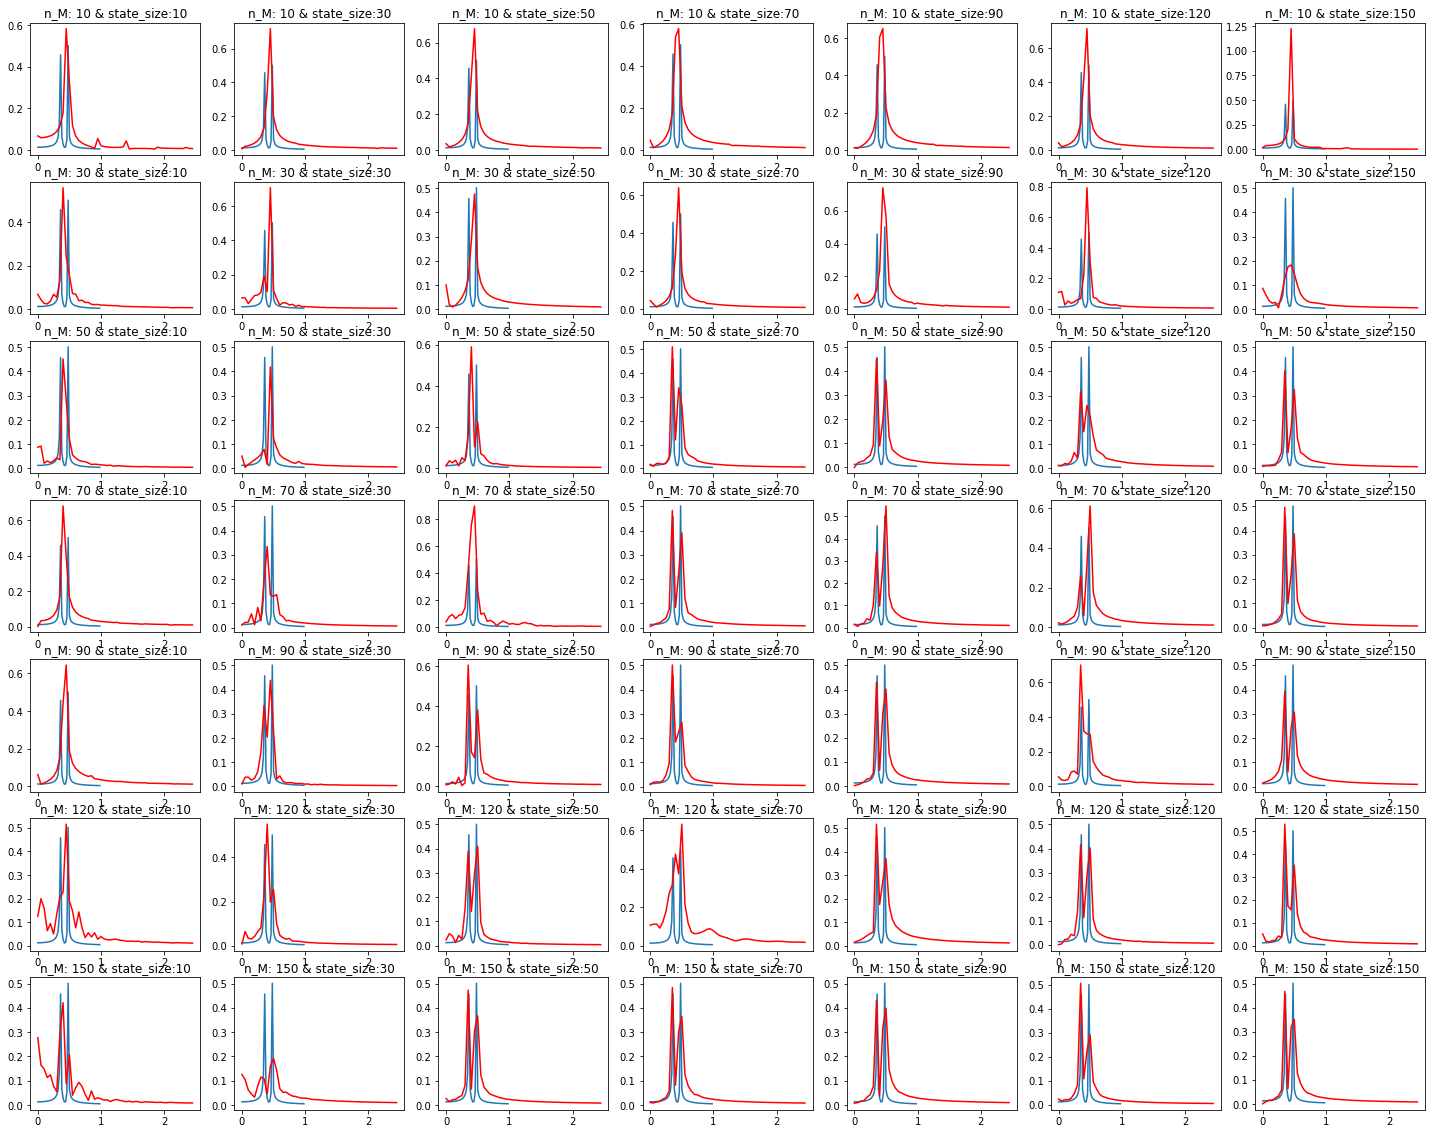

In [163]:
fig, ax = plt.subplots(n_M_list.size,n_M_list.size,figsize=(25,20))
c = 0
for i in range(n_M_list.size):
    for j in range(state_size_list.size):
        n_M = n_M_list[i]
        state_size = state_size_list[j]
        gt, pred = model_list[c].get_pred()
        # Plot fft
        fft = fast_fourier(pred[1])
        ax[i, j].set_title('n_M: '+str(n_M) +' & state_size:'+str(state_size))
        ax[i, j].plot(frequencies[0:50], abs(fourierTransform)[0:50])
        ax[i, j].plot(fft[0][0:50],abs(fft[1][0:50]),c='r')
        c += 1

In [153]:
n_M_list = np.array([120,130])
state_size_list = np.array([120,130])

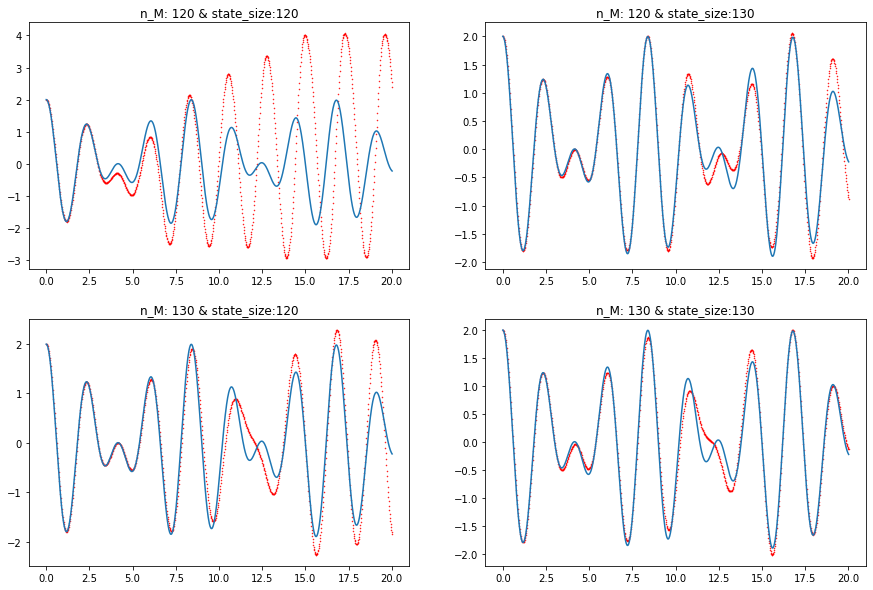

In [154]:
fig, ax = plt.subplots(n_M_list.size,state_size_list.size,figsize=(15,10))
model_list_2 = []
for i in range(n_M_list.size):
    for j in range(state_size_list.size):
        n_M = n_M_list[i]
        state_size = state_size_list[j]
        gt, pred, test = run_model(n_M,state_size)
        model_list_2.append(test)
        # Plot q
        ax[i, j].set_title('n_M: '+str(n_M) +' & state_size:'+str(state_size))
        ax[i, j].plot(gt[0],gt[1])
        ax[i, j].scatter(pred[0],pred[1],c='r',s=.25)

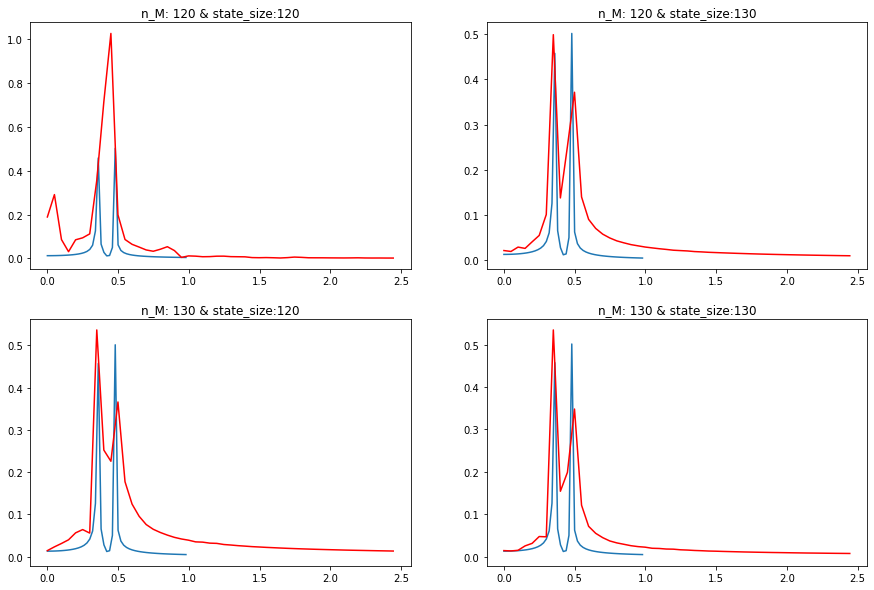

In [156]:
fig, ax = plt.subplots(n_M_list.size,n_M_list.size,figsize=(15,10))
c = 0
for i in range(n_M_list.size):
    for j in range(state_size_list.size):
        n_M = n_M_list[i]
        state_size = state_size_list[j]
        gt, pred = model_list_2[c].get_pred()
        # Plot fft
        fft = fast_fourier(pred[1])
        ax[i, j].set_title('n_M: '+str(n_M) +' & state_size:'+str(state_size))
        ax[i, j].plot(frequencies[0:50], abs(fourierTransform)[0:50])
        ax[i, j].plot(fft[0][0:50],abs(fft[1][0:50]),c='r')
        c += 1